August: Defining transport sections on the plane that cuts vertically at the shelf break. This is specifically for U transport.

In [136]:
import numpy as np
import netCDF4 as nc
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from salishsea_tools.nc_tools import scDataset

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

In [1]:
! ncdump -h /ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/1_mesh_mask.nc

netcdf \1_mesh_mask {
dimensions:
	x = 244 ;
	y = 274 ;
	z = 80 ;
	t = UNLIMITED ; // (1 currently)
variables:
	float nav_lon(y, x) ;
	float nav_lat(y, x) ;
	float nav_lev(z) ;
	double time_counter(t) ;
	byte tmask(t, z, y, x) ;
	byte umask(t, z, y, x) ;
	byte vmask(t, z, y, x) ;
	byte fmask(t, z, y, x) ;
	byte tmaskutil(t, y, x) ;
	byte umaskutil(t, y, x) ;
	byte vmaskutil(t, y, x) ;
	byte fmaskutil(t, y, x) ;
	float glamt(t, y, x) ;
	float glamu(t, y, x) ;
	float glamv(t, y, x) ;
	float glamf(t, y, x) ;
	float gphit(t, y, x) ;
	float gphiu(t, y, x) ;
	float gphiv(t, y, x) ;
	float gphif(t, y, x) ;
	double e1t(t, y, x) ;
	double e1u(t, y, x) ;
	double e1v(t, y, x) ;
	double e1f(t, y, x) ;
	double e2t(t, y, x) ;
	double e2u(t, y, x) ;
	double e2v(t, y, x) ;
	double e2f(t, y, x) ;
	double ff(t, y, x) ;
	short mbathy(t, y, x) ;
	short misf(t, y, x) ;
	float isfdraft(t, y, x) ;
	double e3t_0(t, z, y, x) ;
	double e3u_0(t, z, y, x) ;
	double e3v_0(t, z, y, x) ;
	double e3w_0(t, z, y, x) ;


In [2]:
def get_variables_planes(dirname, filename):
    with nc.Dataset(os.path.join(dirname, filename), 'r') as nbl:
        x, y =  slice(1,-1,None), slice(1,-1,None)
        gdepu = nbl.variables['gdepu'][0, :, 1, 1]
        umask = nbl.variables['umask'][0, :, y, x]
        mbathy = nbl.variables['mbathy'][0, y, x]
        e2u = nbl.variables['e2u'][0, y, x]
        e3u_0 = nbl.variables['e3u_0'][0, :, y, x]  
        return gdepu, umask, mbathy, e2u, e3u_0

In [5]:
dirname = '/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
filename = '1_mesh_mask.nc'

In [128]:
# z index of the shelf platform
# 1. find where the depth of v point is closest to 80
# 2. re-assess answer later
ind_shelf = np.argmin(np.abs(gdepu - 80))

# y index of shelf break 
# 1. get top view of umask at shelf depth
# 2. extract wet/dry values along x=1 
# 3. find the first wet cell
ind_plane = np.where(umask[ind_shelf, :, 1] == 1)[0][0]

print('ind_plane', ind_plane)

# z index of the shelf platform
cells_shelf = umask[ind_shelf, ind_plane, :]
cells_shelf_W = np.count_nonzero(cells_shelf)
cells_shelf_D = umask.shape[-1] - cells_shelf_W
while cells_shelf_D < 4:
    ind_shelf += 1
    cells_shelf = umask[ind_shelf, ind_plane, :]
    cells_shelf_W = np.count_nonzero(cells_shelf)
    cells_shelf_D = umask.shape[-1] - cells_shelf_W
depth_shelf = gdepu[ind_shelf]

print('ind_shelf', ind_shelf)
print('depth_shelf', depth_shelf)

# z index of canyon bottom
# 1. mbathy gives maximum depth level everywhere
# 2. this value is given in fortran indexing
# 3. subtracting 1 gives the deepest level with wet cells
ind_bottom = (mbathy[ind_plane,:].max())-1
depth_bottom = gdepu[ind_bottom]

print('ind_bottom', ind_bottom)
print('depth_bottom', depth_bottom)

# x index of canyon axis
# 1. find all wet cells along canyon bottom
# 2. find the middle wet cell for symmetric axis
# 3. this could have a 0.5 so return integer

ind_axis = int(np.median(np.where(umask[ind_bottom, ind_plane, :]==1)))
print('ind_axis', ind_axis)

# x index of rims
# 1. last land value on left
# 2. first land value on right
ind_rimW0 = np.where(umask[ind_shelf, ind_plane, :ind_axis]==0)[0][-1]
ind_rimE0 = np.where(umask[ind_shelf, ind_plane, ind_axis:]==0)[0][0] + ind_axis
axis_to_rim = min(ind_rimE0 - ind_axis, ind_axis - ind_rimW0)
ind_rimW = ind_axis - axis_to_rim
ind_rimE = ind_axis + axis_to_rim

print('ind_rimW', ind_rimW)
print('ind_rimE', ind_rimE)

# z index of half canyon
# 1. area of individual wet cells
cell_x_i = e2u[ind_plane, :]
cell_y_i = e3u_0[:, ind_plane, :]
area_i = umask[:, ind_plane, :] * cell_x_i * cell_y_i

# 2. total area of every depth level
area_all = np.zeros(area_i.shape[0])
for depth_ind in range(area_i.shape[0]):
    area_all[depth_ind] = area_i[depth_ind, :].sum()

# 3. areas and indices of only the depth levels inside the canyon
area_canyon = area_all[ind_shelf:ind_bottom]
area_canyon_inds = np.arange(ind_shelf,ind_bottom)

# 4. half the area of the canyon
total_area_canyon = np.sum(area_canyon)
half_area_canyon = total_area_canyon / 2

# 5. relative level where cumulative area is closest to the half area
cumsum_area_canyon = np.cumsum(area_canyon)
relative_ind_half = (np.abs(cumsum_area_canyon-half_area_canyon)).argmin()

# 6. the real depth level for half area
ind_half = area_canyon_inds[relative_ind_half]
depth_half = gdepu[ind_half]

print('ind_half', ind_half)
print('depth_half', depth_half)

# x index of shelves
# 1. try to make shf sections same width as rim sections
# 2. if 4 cells away from edge, bring closer to centre
# 3. find smallest distance from centre and use as width
ind_shfW0 = ind_rimW - axis_to_rim
ind_shfE0 = ind_rimE + axis_to_rim
while ind_shfW0 <= 4:
    ind_shfW0 += 1
while ind_shfE0 >= umask.shape[-1]-4:
    ind_shfE0 -= 1
axis_to_shf = min(ind_shfE0 - ind_axis, ind_axis - ind_shfW0)
ind_shfW = ind_axis - axis_to_shf
ind_shfE = ind_axis + axis_to_shf

print('ind_shfW', ind_shfW)
print('ind_shfE', ind_shfE)

ind_plane 178
ind_shelf 10
depth_shelf 91.875
ind_bottom 60
depth_bottom 534.672
ind_axis 109
ind_rimW 48
ind_rimE 170
ind_half 25
depth_half 223.125
ind_shfW 5
ind_shfE 213


In [125]:
inds = np.zeros([len(area_canyon_inds), 2])
for dep_ind, canyon_ind in zip(np.arange(len(area_canyon_inds)), area_canyon_inds):
    row_cells = umask[canyon_ind, ind_plane, :]
    row_wet = np.where(row_cells == 1)[0]
    if len(row_wet) > len(row_cells) - 2:
        inds[dep_ind, 0] = np.nan
        inds[dep_ind, 1] = np.nan
    else:
        inds[dep_ind, 0] = row_wet[0] + 5
        inds[dep_ind, 1] = row_wet[-1] - 5

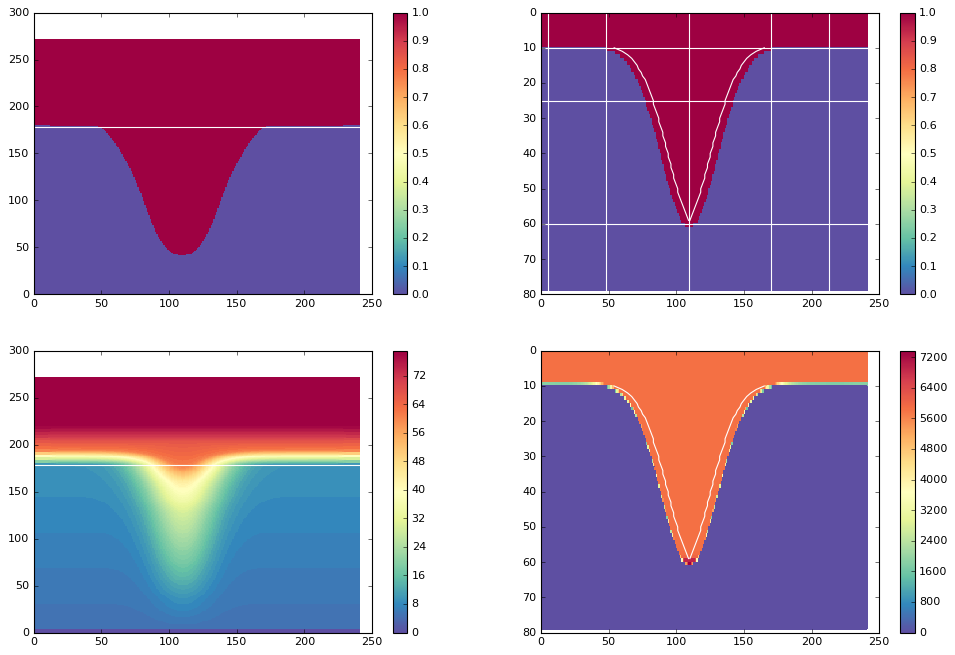

In [129]:
xs = np.arange(umask.shape[-1])
ys = np.arange(umask.shape[-2])
zs = np.arange(umask.shape[-3])

fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2,figsize=(15,10))
p1 = ax1.pcolormesh(xs, ys, umask[ind_shelf, :, :], cmap=cm.Spectral_r)
p2 = ax2.pcolormesh(xs, zs, umask[:, ind_plane, :], cmap=cm.Spectral_r)
p3 = ax3.pcolormesh(xs, ys, mbathy, cmap=cm.Spectral_r)
p4 = ax4.pcolormesh(xs, zs, area_i, cmap=cm.Spectral_r)
fig.colorbar(p1, ax=ax1)
fig.colorbar(p2, ax=ax2)
fig.colorbar(p3, ax=ax3)
fig.colorbar(p4, ax=ax4)
ax2.invert_yaxis()
ax4.invert_yaxis()

ax1.axhline(ind_plane, c='white')
ax2.axhline(ind_shelf, c='white')
ax2.axhline(ind_bottom, c='white')
ax2.axvline(ind_axis, c='white')
ax3.axhline(ind_plane, c='white')
ax2.axvline(ind_rimW, c='white')
ax2.axvline(ind_rimE, c='white')
ax2.axhline(ind_half, c='white')
ax2.axvline(ind_shfW, c='white')
ax2.axvline(ind_shfE, c='white')

for ax in ([ax2,  ax4]):
    ax.plot(inds[:, 0], area_canyon_inds, c='white')
    ax.plot(inds[:, 1], area_canyon_inds, c='white')

# $Q_i = u \times e2u \times e3u = u \times A_i$

In [143]:
def get_variables_fluxes(dirname, filepattern, ind_plane, umask):
    files = general_functions.get_files(dirname, filepattern, 'grid_U')
    x, y =  slice(1,-1,None), int(ind_plane)
    with scDataset(files) as ds:
        vozocrtx0 = ds.variables['vozocrtx'][:, :, y, x]
    umask0 = umask[:, y, :]
    umask = np.tile(umask0, (vozocrtx0.shape[0],1, 1))  
    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    return vozocrtx

# ------------------------------------------------------------------------------------------------

def calculate_flux_U(time_ind, velocity_plane, area_plane):
    '''Calculates flux at all cells at one time.
    velocity_plane (t, z, x)
    area_plane(z, x)
    '''
    Q_plane = velocity_plane[time_ind, :, :] * area_plane
    return Q_plane

# ------------------------------------------------------------------------------------------------

def calculate_flux_U_evolution(velocity_plane, area_plane):
    '''Calculates flux at all cells at all times.
    velocity_plane (t, z, x)
    area_plane(z, x)
    '''
    Q_plane_all = np.zeros_like(velocity_plane)
    for time_ind in range(Q_plane_all.shape[0]):
        Q_plane_all[time_ind, :, :] = calculate_flux_U(time_ind, velocity_plane, area_plane)
    return Q_plane_all

In [137]:
filepattern = "1_MCKNZ_1h_20170101_20170120_*"
vozocrtx = get_variables_fluxes(dirname, filepattern, ind_plane, umask)

In [145]:
Q_i_all = calculate_flux_U_evolution(vozocrtx, area_i)

In [146]:
Q_i_all.shape

(480, 80, 242)